In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import math

In [3]:
labels = gpd.read_file('data/processed-labels/labels_all_chicago/labels_all_chicago.shp')
curb = labels.loc[(labels['label_type']=='CurbRamp')]
curb = curb.to_crs("EPSG:2285")
no_curb = labels.loc[(labels['label_type']=='NoCurbRamp')]
no_curb = no_curb.to_crs("EPSG:2285")
crosswalk = labels.loc[(labels['label_type']=='Crosswalk')]
crosswalk = crosswalk.to_crs("EPSG:2285")

In [5]:
#read in shapefile data/seattle-osm-roads.shp
roads = gpd.read_file('data/chicago-osm-roads/chicago-osm-roads.shp')

In [5]:
#roads.explore( column='highway', tiles='cartodbpositron', cmap='Set2')

In [6]:
#change highway column name to way_type
roads.rename(columns={'highway':'way_type'}, inplace=True)

In [7]:
#drop way_type = motorway and motorway_link
roads = roads[roads.way_type != 'motorway']
roads = roads[roads.way_type != 'motorway_link']

In [8]:
roads

,way_type,osmid,geometry
0,residential,24072266,"LINESTRING (-87.97804 42.08236, -87.97804 42.0..."
1,service,889494360,"LINESTRING (-87.97804 42.08236, -87.97823 42.0..."
2,service,889494358,"LINESTRING (-87.97804 42.08236, -87.97823 42.0..."
3,service,889494359,"LINESTRING (-87.97804 42.08236, -87.97823 42.0..."
4,residential,24072266,"LINESTRING (-87.97804 42.08236, -87.97804 42.0..."
...,...,...,...
53597,service,1153985270,"LINESTRING (-87.64020 41.61787, -87.64021 41.6..."
53598,primary,360448907,"LINESTRING (-87.64023 41.61771, -87.64018 41.6..."
53599,primary,360448907,"LINESTRING (-87.64023 41.61771, -87.64038 41.6..."
53600,service,1153985271,"LINESTRING (-87.64023 41.61771, -87.64035 41.6..."


In [9]:
# Extract start and end coordinates of each linestring
first_coord = roads["geometry"].apply(lambda g: g.coords[0])
last_coord = roads["geometry"].apply(lambda g: g.coords[-1])

# Add start and end as columns to the s
roads["start_coord"] = first_coord
roads["end_coord"] = last_coord

In [10]:
p0 = roads[['start_coord', 'way_type']]
p1 = roads[['end_coord','way_type']]
p0 = p0.rename(columns={'start_coord':'coord'})
p1 = p1.rename(columns={'end_coord':'coord'})
result = pd.concat([p0,p1])
result = result.drop_duplicates(subset=['coord','way_type'], keep='first')
result

,coord,way_type
0,"(-87.9780429, 42.0823594)",residential
1,"(-87.9780429, 42.0823594)",service
6,"(-87.9877593, 42.0901748)",residential
9,"(-87.9877604, 42.0915664)",residential
12,"(-87.9902354, 42.0828528)",residential
...,...,...
53596,"(-87.6402086, 41.6180306)",service
53597,"(-87.6402022, 41.617871)",service
53598,"(-87.6402309, 41.6177108)",primary
53600,"(-87.6402309, 41.6177108)",service


In [11]:
#convert points into gpd
points = result.apply(lambda row: Point(row), axis=1)
#fix coordinate system
p_geo = gpd.GeoDataFrame(result, geometry=points)
p_geo.crs = {'init': 'epsg:4326'}
p_geo = p_geo.to_crs("EPSG:2285")
p_geo

,coord,way_type,geometry
0,"(-87.9780429, 42.0823594)",residential,POINT (10336916.177 88454.254)
1,"(-87.9780429, 42.0823594)",service,POINT (10336916.177 88454.254)
6,"(-87.9877593, 42.0901748)",residential,POINT (10333317.214 89962.696)
9,"(-87.9877604, 42.0915664)",residential,POINT (10333105.900 90426.641)
12,"(-87.9902354, 42.0828528)",residential,POINT (10333812.505 87241.222)
...,...,...,...
53596,"(-87.6402086, 41.6180306)",service,POINT (10491896.780 -27768.880)
53597,"(-87.6402022, 41.617871)",service,POINT (10491922.843 -27821.298)
53598,"(-87.6402309, 41.6177108)",primary,POINT (10491940.225 -27877.953)
53600,"(-87.6402309, 41.6177108)",service,POINT (10491940.225 -27877.953)


In [12]:
#Spatial join project sidewalk labels to sidewalk geometry
curb_to_intersection = curb.sjoin_nearest(p_geo, distance_col='distance')
curb_to_intersection

,audit_task,label_id,gsv_panora,label_type,severity,correct,high_quali,gsv_pano_1,zoom,heading,pitch,photograph,photogra_1,user_id,lat,lng,geometry,index_right,coord,way_type,distance
0,3,8,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,2.0,None,1,pMph48Z6Xz2hexFJ7q3d_Q,2,136.687500,-18.625000,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083668,-87.980347,POINT (10336145.430 88630.219),300,"(-87.9804741, 42.0837429)",service,44.351012
3,3,11,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,3.0,1,1,pMph48Z6Xz2hexFJ7q3d_Q,3,49.245537,-16.220982,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083794,-87.980354,POINT (10336124.440 88671.336),300,"(-87.9804741, 42.0837429)",service,37.606204
4,3,12,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,3.0,1,1,pMph48Z6Xz2hexFJ7q3d_Q,3,42.636162,-16.033482,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083817,-87.980362,POINT (10336119.072 88678.106),300,"(-87.9804741, 42.0837429)",service,40.797927
0,3,8,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,2.0,None,1,pMph48Z6Xz2hexFJ7q3d_Q,2,136.687500,-18.625000,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083668,-87.980347,POINT (10336145.430 88630.219),301,"(-87.9804741, 42.0837429)",secondary,44.351012
3,3,11,pMph48Z6Xz2hexFJ7q3d_Q,CurbRamp,3.0,1,1,pMph48Z6Xz2hexFJ7q3d_Q,3,49.245537,-16.220982,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,42.083794,-87.980354,POINT (10336124.440 88671.336),301,"(-87.9804741, 42.0837429)",secondary,37.606204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18270,4588,21496,g2bClkWMQjCLoNVtPMkLUA,CurbRamp,2.0,None,1,g2bClkWMQjCLoNVtPMkLUA,1,91.091515,-31.062500,179.339081,0.205020,71959a82-3f47-4dec-a02b-86669bf8095b,41.611763,-87.664299,POINT (10486835.683 -32626.514),31901,"(-87.6644137, 41.6117242)",residential,34.614497
18271,4588,21497,htYgFrypIVbNnNTSpoHjxQ,CurbRamp,3.0,None,1,htYgFrypIVbNnNTSpoHjxQ,1,144.904022,-35.000000,179.118057,0.400970,71959a82-3f47-4dec-a02b-86669bf8095b,41.611675,-87.664291,POINT (10486851.030 -32654.862),31901,"(-87.6644137, 41.6117242)",residential,38.139346
18272,4588,21498,htYgFrypIVbNnNTSpoHjxQ,CurbRamp,3.0,None,1,htYgFrypIVbNnNTSpoHjxQ,1,144.904022,-35.000000,179.118057,0.400970,71959a82-3f47-4dec-a02b-86669bf8095b,41.611633,-87.664352,POINT (10486842.199 -32675.856),31901,"(-87.6644137, 41.6117242)",residential,37.349250
18273,4588,21499,htYgFrypIVbNnNTSpoHjxQ,CurbRamp,2.0,None,1,htYgFrypIVbNnNTSpoHjxQ,1,207.904022,-34.812500,179.118057,0.400970,71959a82-3f47-4dec-a02b-86669bf8095b,41.611633,-87.664497,POINT (10486805.962 -32692.519),31901,"(-87.6644137, 41.6117242)",residential,40.505649


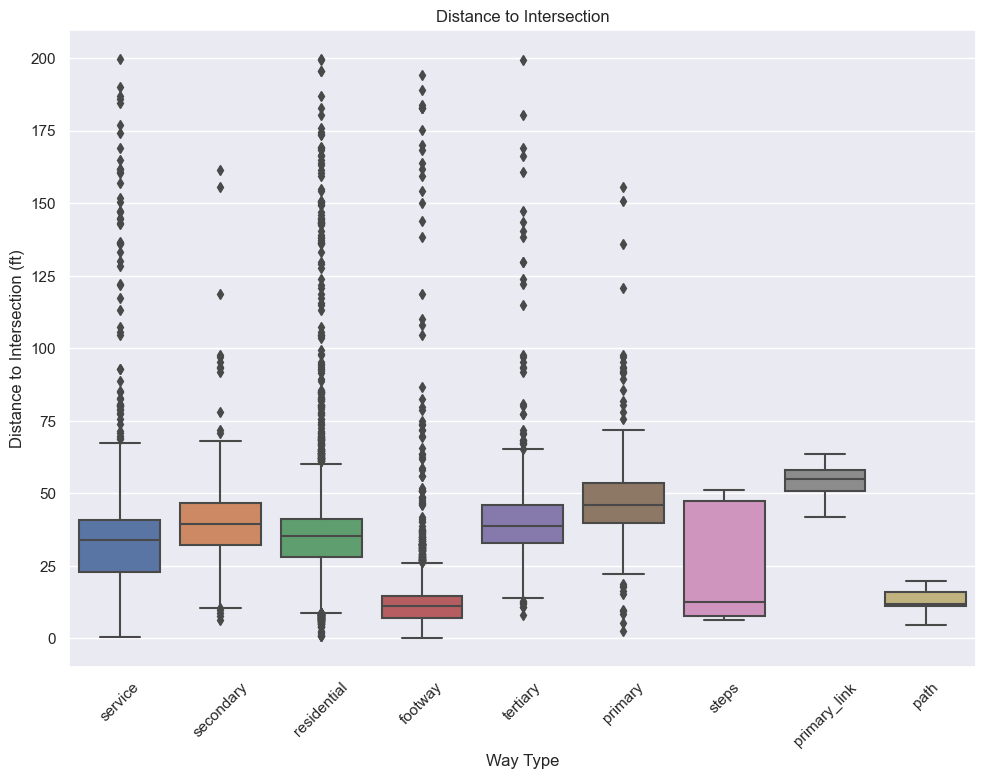

In [13]:
#select distance < 200 ft and do the same plot
distance_to_intersection = curb_to_intersection.loc[(curb_to_intersection['distance']<200)]
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x="way_type", y="distance", data=distance_to_intersection)
ax.set_title('Distance to Intersection')
ax.set_xlabel('Way Type')
ax.set_ylabel('Distance to Intersection (ft)')
#rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

In [14]:
#select only label_id, way_type, distance
curb_to_intersection = curb_to_intersection[['label_id','way_type','distance']]

In [15]:
curb_to_intersection

,label_id,way_type,distance
0,8,service,44.351012
3,11,service,37.606204
4,12,service,40.797927
0,8,secondary,44.351012
3,11,secondary,37.606204
...,...,...,...
18270,21496,residential,34.614497
18271,21497,residential,38.139346
18272,21498,residential,37.349250
18273,21499,residential,40.505649


In [16]:
#Spatial join project sidewalk labels to sidewalk geometry
no_curb_to_intersection = no_curb.sjoin_nearest(p_geo, distance_col='distance')
no_curb_to_intersection

,audit_task,label_id,gsv_panora,label_type,severity,correct,high_quali,gsv_pano_1,zoom,heading,pitch,photograph,photogra_1,user_id,lat,lng,geometry,index_right,coord,way_type,distance
22,10,30,ts6P8ubSQ-lR3AcL0Hvbbg,NoCurbRamp,3.0,0,1,ts6P8ubSQ-lR3AcL0Hvbbg,1,213.366074,-22.102678,24.008078,1.126106,9eff1ebb-c702-4ac9-b580-b3897e2b8ec8,41.577240,-87.661766,POINT (10492757.415 -43835.074),34219,"(-87.6617436, 41.577366)",residential,46.613246
60,17,76,O2OMM5FtwMoEShhjlsUQGA,NoCurbRamp,5.0,1,1,O2OMM5FtwMoEShhjlsUQGA,1,144.625000,-27.062500,89.791985,0.340286,9eff1ebb-c702-4ac9-b580-b3897e2b8ec8,41.823620,-87.626854,POINT (10463715.905 42221.169),16028,"(-87.6266199, 41.823629)",footway,64.247816
3765,900,4343,8VkUZtN-xn1bQEi927-QOw,NoCurbRamp,3.0,1,1,8VkUZtN-xn1bQEi927-QOw,3,259.464294,-11.607142,87.230980,-0.083649,6ab0ea11-9cd2-492f-b750-2e83aa140f29,41.823631,-87.626884,POINT (10463706.552 42221.479),16028,"(-87.6266199, 41.823629)",footway,72.530963
89,17,108,7hP5t46uVIYvHwTeiZChaQ,NoCurbRamp,1.0,1,1,7hP5t46uVIYvHwTeiZChaQ,3,324.234375,-11.131697,88.896873,-0.112373,9eff1ebb-c702-4ac9-b580-b3897e2b8ec8,41.823792,-87.627708,POINT (10463476.815 42180.347),15999,"(-87.6277044, 41.8237861)",footway,2.268500
3644,817,4056,Fo3e91UrZMW_Z1W-FqZ-hA,NoCurbRamp,3.0,None,1,Fo3e91UrZMW_Z1W-FqZ-hA,2,340.562500,-7.000000,88.845352,-0.099022,7f98ef99-f57f-455c-a6cb-d20e99e53082,41.823795,-87.627701,POINT (10463478.130 42182.492),15999,"(-87.6277044, 41.8237861)",footway,3.519366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18204,4581,21415,tn_jCOPVYNYi-0kzOSuWxQ,NoCurbRamp,5.0,1,1,tn_jCOPVYNYi-0kzOSuWxQ,1,55.250000,-16.187500,359.758636,2.109820,44116ebd-4409-4ce5-84fa-3fed61f84d13,41.597343,-87.641190,POINT (10494822.426 -34771.675),29108,"(-87.6412959, 41.5973009)",residential,33.160180
18204,4581,21415,tn_jCOPVYNYi-0kzOSuWxQ,NoCurbRamp,5.0,1,1,tn_jCOPVYNYi-0kzOSuWxQ,1,55.250000,-16.187500,359.758636,2.109820,44116ebd-4409-4ce5-84fa-3fed61f84d13,41.597343,-87.641190,POINT (10494822.426 -34771.675),29109,"(-87.6412959, 41.5973009)",service,33.160180
18219,4582,21432,SY_hDVRU_YxWcvOJOhXdag,NoCurbRamp,5.0,None,1,SY_hDVRU_YxWcvOJOhXdag,2,37.000000,-16.000000,358.259674,0.904366,44116ebd-4409-4ce5-84fa-3fed61f84d13,41.599167,-87.641243,POINT (10494529.585 -34170.508),31830,"(-87.6412946, 41.5991021)",residential,27.671919
18220,4582,21433,SY_hDVRU_YxWcvOJOhXdag,NoCurbRamp,5.0,0,1,SY_hDVRU_YxWcvOJOhXdag,2,37.000000,-16.000000,358.259674,0.904366,44116ebd-4409-4ce5-84fa-3fed61f84d13,41.599136,-87.641190,POINT (10494547.614 -34174.528),31830,"(-87.6412946, 41.5991021)",residential,31.513953


In [17]:
#select only label_id, way_type, distance
no_curb_to_intersection = no_curb_to_intersection[['label_id','way_type','distance']]

In [18]:
crosswalk_to_intersection = no_curb.sjoin_nearest(p_geo, distance_col='distance')
crosswalk_to_intersection

,audit_task,label_id,gsv_panora,label_type,severity,correct,high_quali,gsv_pano_1,zoom,heading,pitch,photograph,photogra_1,user_id,lat,lng,geometry,index_right,coord,way_type,distance
22,10,30,ts6P8ubSQ-lR3AcL0Hvbbg,NoCurbRamp,3.0,0,1,ts6P8ubSQ-lR3AcL0Hvbbg,1,213.366074,-22.102678,24.008078,1.126106,9eff1ebb-c702-4ac9-b580-b3897e2b8ec8,41.577240,-87.661766,POINT (10492757.415 -43835.074),34219,"(-87.6617436, 41.577366)",residential,46.613246
60,17,76,O2OMM5FtwMoEShhjlsUQGA,NoCurbRamp,5.0,1,1,O2OMM5FtwMoEShhjlsUQGA,1,144.625000,-27.062500,89.791985,0.340286,9eff1ebb-c702-4ac9-b580-b3897e2b8ec8,41.823620,-87.626854,POINT (10463715.905 42221.169),16028,"(-87.6266199, 41.823629)",footway,64.247816
3765,900,4343,8VkUZtN-xn1bQEi927-QOw,NoCurbRamp,3.0,1,1,8VkUZtN-xn1bQEi927-QOw,3,259.464294,-11.607142,87.230980,-0.083649,6ab0ea11-9cd2-492f-b750-2e83aa140f29,41.823631,-87.626884,POINT (10463706.552 42221.479),16028,"(-87.6266199, 41.823629)",footway,72.530963
89,17,108,7hP5t46uVIYvHwTeiZChaQ,NoCurbRamp,1.0,1,1,7hP5t46uVIYvHwTeiZChaQ,3,324.234375,-11.131697,88.896873,-0.112373,9eff1ebb-c702-4ac9-b580-b3897e2b8ec8,41.823792,-87.627708,POINT (10463476.815 42180.347),15999,"(-87.6277044, 41.8237861)",footway,2.268500
3644,817,4056,Fo3e91UrZMW_Z1W-FqZ-hA,NoCurbRamp,3.0,None,1,Fo3e91UrZMW_Z1W-FqZ-hA,2,340.562500,-7.000000,88.845352,-0.099022,7f98ef99-f57f-455c-a6cb-d20e99e53082,41.823795,-87.627701,POINT (10463478.130 42182.492),15999,"(-87.6277044, 41.8237861)",footway,3.519366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18204,4581,21415,tn_jCOPVYNYi-0kzOSuWxQ,NoCurbRamp,5.0,1,1,tn_jCOPVYNYi-0kzOSuWxQ,1,55.250000,-16.187500,359.758636,2.109820,44116ebd-4409-4ce5-84fa-3fed61f84d13,41.597343,-87.641190,POINT (10494822.426 -34771.675),29108,"(-87.6412959, 41.5973009)",residential,33.160180
18204,4581,21415,tn_jCOPVYNYi-0kzOSuWxQ,NoCurbRamp,5.0,1,1,tn_jCOPVYNYi-0kzOSuWxQ,1,55.250000,-16.187500,359.758636,2.109820,44116ebd-4409-4ce5-84fa-3fed61f84d13,41.597343,-87.641190,POINT (10494822.426 -34771.675),29109,"(-87.6412959, 41.5973009)",service,33.160180
18219,4582,21432,SY_hDVRU_YxWcvOJOhXdag,NoCurbRamp,5.0,None,1,SY_hDVRU_YxWcvOJOhXdag,2,37.000000,-16.000000,358.259674,0.904366,44116ebd-4409-4ce5-84fa-3fed61f84d13,41.599167,-87.641243,POINT (10494529.585 -34170.508),31830,"(-87.6412946, 41.5991021)",residential,27.671919
18220,4582,21433,SY_hDVRU_YxWcvOJOhXdag,NoCurbRamp,5.0,0,1,SY_hDVRU_YxWcvOJOhXdag,2,37.000000,-16.000000,358.259674,0.904366,44116ebd-4409-4ce5-84fa-3fed61f84d13,41.599136,-87.641190,POINT (10494547.614 -34174.528),31830,"(-87.6412946, 41.5991021)",residential,31.513953


In [19]:
#select only label_id, way_type, distance
crosswalk_to_intersection = crosswalk_to_intersection[['label_id','way_type','distance']]

In [20]:
#concatenate curb and no curb
intersection_d = pd.concat([curb_to_intersection, no_curb_to_intersection, crosswalk_to_intersection])

In [21]:
# rename distance to distance_to_intersection
intersection_d = intersection_d.rename(columns={'distance':'intersection_distance'})
intersection_d

,label_id,way_type,intersection_distance
0,8,service,44.351012
3,11,service,37.606204
4,12,service,40.797927
0,8,secondary,44.351012
3,11,secondary,37.606204
...,...,...,...
18204,21415,residential,33.160180
18204,21415,service,33.160180
18219,21432,residential,27.671919
18220,21433,residential,31.513953


In [22]:
df = labels[['label_id']]

In [23]:
df

,label_id
0,8
1,9
2,10
3,11
4,12
...,...
18280,21507
18281,21508
18282,21509
18283,21517


In [24]:
#merge labels and intersection_d
df = df.merge(intersection_d, on='label_id', how='left')

In [25]:
#group by label_id choose first way_type and distance
df = df.groupby('label_id').first().reset_index()
df = df.fillna(-1)
df

,label_id,way_type,intersection_distance
0,8,service,44.351012
1,9,service,17.967994
2,10,footway,12.865493
3,11,service,37.606204
4,12,service,40.797927
...,...,...,...
18280,21507,-1,-1.000000
18281,21508,-1,-1.000000
18282,21509,residential,45.805749
18283,21517,residential,39.930634


In [26]:
df.to_csv('data/features/intersection_distance.csv', index=False)